In [9]:
#this prototype just looks at batch_size and epochs

#load all packages

import sys

sys.path

sys.executable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random
import tensorflow as tf
from tensorflow import keras

np.random.seed(1337)


from keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split

In [13]:
#call the model you are trying to optimize
#for every parameter you want to run, you need to put the variable in the function

def train_model(x, y, border_mode='same', inp_len=133, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3, batch_size=128, optimizer="Adam", activation="relu"):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)
    

    model.fit(x, y, batch_size=20, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler() #sets mrl based on variance rather than mean
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='Alligned Barcode', seq_len=133):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

print("success")

success


In [11]:
df = pd.read_pickle('Alligned Barcodes-50bp flanks/Barcode_mg_133bp_Alligned.pkl')       #mod1-added my own file

df.sort_values('Count Freq', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:1565] 


e_test = df.iloc[:156]  
e_train = df.iloc[156:]  



#X_train, X_test, y_train, y_test = train_test_split(df["Alligned Barcode"], df["Change in Count Freq"], test_size=0.10, random_state=42) 

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=133)
seq_e_test = one_hot_encode(e_test, seq_len=133)

e_train.loc[:, 'Count Freq']
print ("Ready for Grid Search")

Ready for Grid Search


In [6]:
#Grid Search for Individual Parameters

runs=range(0,3)
row=0
#list parameters to test
layers=[3, 4] 
nodes=[300, 400]
nbr_filters= [80,120]            #aka filters
filter_len= [10, 20]               #aka kernel_size
batch_size=[80]
optimizer=[ 'Adam', 'Adamax']
activation = ['relu','linear']

#Make a list of all the Printed Results
Nodes_Results=[]
Layers_Results=[]
Filters_Results=[]
Kernels_Results=[]
Batch_Sizes_Results=[]
Optimizer_Results=[]
Activation_Results=[]
Results=[]


#grid search nodes only
#create data frame
GS_Nodes=pd.DataFrame()
GS_Nodes["Nodes"]=""
GS_Nodes["R_Squared"]=""
for z in runs:
    for i in nodes:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=i, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", activation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there are", i, "nodes,  the r squared value is", r
        Nodes_Results.append(a) 
        GS_Nodes.loc[row]=(i,r)
        row+=1

#grid search layers only
#create data frame
GS_Layers=pd.DataFrame()
GS_Layers["Layers"]=""
GS_Layers["R_Squared"]=""
for z in runs:
    for j in layers:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=j, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", activation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there are", j, "layers,  the r squared value is", r
        Layers_Results.append(a)      
        GS_Layers.loc[row]=(j,r)
        row+=1
        
#grid search filters only
#create data frame
GS_Filters=pd.DataFrame()
GS_Filters["Filters"]=""
GS_Filters["R_Squared"]=""
for z in runs:
    for k in nbr_filters:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=k, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", activation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there are", k, "filters, the r squared value is", r
        Filters_Results.append(a)
        GS_Filters.loc[row]=(k,r)
        row+=1
        
    #grid search kernels only
    #create data frame
GS_Kernels=pd.DataFrame()
GS_Kernels["Kernels"]=""
GS_Kernels["R_Squared"]=""
for z in runs:
    for l in filter_len:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=120, filter_len=l, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", activation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there are", l, "kernels, the r squared value is", r
        Kernels_Results.append(a) 
        GS_Kernels.loc[row]=(l,r)
        row+=1

#grid search batch size only
#create data frame
GS_Batch_Sizes=pd.DataFrame()
GS_Batch_Sizes["Batch Sizes"]=""
GS_Batch_Sizes["R_Squared"]=""
for z in runs:
    for m in batch_size:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=m, optimizer="Adam", activation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)   
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there is a", m, "batch size, the r squared value is", r
        Batch_Sizes_Results.append(a)  
        GS_Batch_Sizes.loc[row]=(m,r)
        row+=1

#grid search optimizer only
#create data frame
GS_Optimizer=pd.DataFrame()
GS_Optimizer["Optimizer"]=""
GS_Optimizer["R_Squared"]=""
for z in runs:
    for n in optimizer:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer=n, activation="relu")
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)   
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there is a", n, "optimizer, the r squared value is", r
        Optimizer_Results.append(a)
        GS_Optimizer.loc[row]=(n,r)
        row+=1

#grid search activation only
#create data frame
GS_Activation=pd.DataFrame()
GS_Activation["Activation"]=""
GS_Activation["R_Squared"]=""
for z in runs:
    for o in activation:
        model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                            inp_len=133, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                            dropout2=0,dropout3=0.2, batch_size=128, optimizer="Adam", activation=o)
        e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)   
        r = r2(e_test['Count Freq'], e_test['pred'])
        e_test['pred']
        a= "When there is a", o, "activation, the r squared value is", r
        Activation_Results.append(a)   
        GS_Activation.loc[row]=(o,r)
        row+=1

Epoch 1/3
71/71 [==============================] - 5s 66ms/step - loss: 0.1463
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 3.8583e-06
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 3.1523e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.2209
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.3602e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 9.1818e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0255
Epoch 2/3
71/71 [==============================] - 5s 65ms/step - loss: 8.3972e-07
Epoch 3/3
71/71 [==============================] - 5s 65ms/step - loss: 2.0282e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1769
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.7039e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.6024e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 65ms/step - loss: 0.1789
Epoch 2/3
71/71 [==============================] - 5s 65ms/step - loss: 2.1264e-06
Epoch 3/3
71/71 [==============================] - 5s 65ms/step - loss: 1.4268e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 69ms/step - loss: 0.1870
Epoch 2/3
71/71 [==============================] - 5s 69ms/step - loss: 7.3258e-07
Epoch 3/3
71/71 [==============================] - 5s 69ms/step - loss: 6.6154e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0229
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.6422e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.7776e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0085
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.8736e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.9859e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0279
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.5798e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.0559e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0145
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 5.8206e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 8.5904e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0667
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.1896e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.1763e-06


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


Epoch 1/3
71/71 [==============================] - 4s 50ms/step - loss: 0.0130
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.4915e-06
Epoch 3/3
71/71 [==============================] - 4s 51ms/step - loss: 1.9124e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 2s 27ms/step - loss: 0.0293
Epoch 2/3
71/71 [==============================] - 2s 27ms/step - loss: 4.4100e-06
Epoch 3/3
71/71 [==============================] - 2s 27ms/step - loss: 3.6393e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 37ms/step - loss: 0.0154
Epoch 2/3
71/71 [==============================] - 3s 37ms/step - loss: 1.8038e-06
Epoch 3/3
71/71 [==============================] - 3s 37ms/step - loss: 2.8595e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0146
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 5.3520e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 8.0668e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 2s 27ms/step - loss: 0.0044
Epoch 2/3
71/71 [==============================] - 2s 27ms/step - loss: 1.6675e-06
Epoch 3/3
71/71 [==============================] - 2s 26ms/step - loss: 8.4825e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 37ms/step - loss: 0.0059
Epoch 2/3
71/71 [==============================] - 3s 37ms/step - loss: 8.8302e-07
Epoch 3/3
71/71 [==============================] - 3s 37ms/step - loss: 7.2955e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0028
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0865e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 4.2608e-09
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 2s 27ms/step - loss: 0.0101
Epoch 2/3
71/71 [==============================] - 2s 27ms/step - loss: 3.2764e-06
Epoch 3/3
71/71 [==============================] - 2s 26ms/step - loss: 2.4055e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 37ms/step - loss: 0.0159
Epoch 2/3
71/71 [==============================] - 3s 37ms/step - loss: 5.7540e-06
Epoch 3/3
71/71 [==============================] - 3s 37ms/step - loss: 9.2158e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0544
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.1620e-05
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 4.5599e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 60ms/step - loss: 0.0260
Epoch 2/3
71/71 [==============================] - 4s 60ms/step - loss: 1.7981e-06
Epoch 3/3
71/71 [==============================] - 4s 60ms/step - loss: 1.5750e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 8s 113ms/step - loss: 0.0253
Epoch 2/3
71/71 [==============================] - 8s 113ms/step - loss: 6.2496e-06
Epoch 3/3
71/71 [==============================] - 8s 113ms/step - loss: 1.5366e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 60ms/step - loss: 0.0017
Epoch 2/3
71/71 [==============================] - 4s 60ms/step - loss: 1.0250e-07
Epoch 3/3
71/71 [==============================] - 4s 60ms/step - loss: 6.1345e-08
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 8s 112ms/step - loss: 0.0188
Epoch 2/3
71/71 [==============================] - 8s 113ms/step - loss: 2.5971e-06
Epoch 3/3
71/71 [==============================] - 8s 113ms/step - loss: 2.0454e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 60ms/step - loss: 0.0072
Epoch 2/3
71/71 [==============================] - 4s 60ms/step - loss: 1.5099e-06
Epoch 3/3
71/71 [==============================] - 4s 60ms/step - loss: 9.3858e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 8s 112ms/step - loss: 0.0085
Epoch 2/3
71/71 [==============================] - 8s 112ms/step - loss: 3.9333e-07
Epoch 3/3
71/71 [==============================] - 8s 112ms/step - loss: 3.2692e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0313
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.1359e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.1288e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 49ms/step - loss: 0.0298
Epoch 2/3
71/71 [==============================] - 4s 49ms/step - loss: 3.4287e-06
Epoch 3/3
71/71 [==============================] - 3s 49ms/step - loss: 2.8901e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 49ms/step - loss: 0.0446
Epoch 2/3
71/71 [==============================] - 4s 49ms/step - loss: 1.0629e-05
Epoch 3/3
71/71 [==============================] - 4s 49ms/step - loss: 3.7642e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0173
Epoch 2/3
71/71 [==============================] - 4s 49ms/step - loss: 4.0679e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.7266e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0121
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.8378e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.8174e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0082
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3253e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 7.2268e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0156
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0976e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 7.9131e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0414
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.7356e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.9576e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0159
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.0505e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 9.7997e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0290
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 8.7326e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.3507e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0362
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.1322e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.7039e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0165
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.9304e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3002e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0246
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.1592e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.3733e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0180
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.1281e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.6879e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0282
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 8.3434e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.2171e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0309
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 3.1398e-06
Epoch 3/3
71/71 [==============================] - 4s 49ms/step - loss: 2.4651e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0047
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 9.4022e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 4.5184e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0091
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 8.8993e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 7.8258e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0114
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.8732e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.0226e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0194
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 2.7883e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 2.1684e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0116
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.5879e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.7472e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0287
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.9131e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5188e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0123
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3883e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 9.8211e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0112
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.5543e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 1.3701e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0142
Epoch 2/3
71/71 [==============================] - 4s 49ms/step - loss: 2.7555e-06
Epoch 3/3
71/71 [==============================] - 4s 49ms/step - loss: 1.7926e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0125
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 6.0641e-06
Epoch 3/3
71/71 [==============================] - 4s 49ms/step - loss: 7.5450e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0103
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 1.1529e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 7.0731e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0159
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 4.6262e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.0035e-06
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 50ms/step - loss: 0.0088
Epoch 2/3
71/71 [==============================] - 4s 50ms/step - loss: 9.6547e-07
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 5.2843e-07
Epoch 1/3


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 51ms/step - loss: 0.0087
Epoch 2/3
71/71 [==============================] - 4s 51ms/step - loss: 4.1483e-06
Epoch 3/3
71/71 [==============================] - 4s 50ms/step - loss: 3.2066e-07


/tmp/ipykernel_1952487/1632939407.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


   Nodes  R_Squared
0  300.0   0.000000
1  400.0   0.005658
2  300.0   0.000011
3  400.0   0.002381
4  300.0   0.002742
5  400.0   0.000144
('When there are', 300, 'nodes,  the r squared value is', 0.0)
('When there are', 400, 'nodes,  the r squared value is', 0.005658266572685479)
('When there are', 300, 'nodes,  the r squared value is', 1.1088097006674958e-05)
('When there are', 400, 'nodes,  the r squared value is', 0.0023814770696554185)
('When there are', 300, 'nodes,  the r squared value is', 0.002741856801300603)
('When there are', 400, 'nodes,  the r squared value is', 0.00014350735237667034)
       R_Squared
Nodes           
300.0   0.000918
400.0   0.002728
    Layers  R_Squared
6      3.0   0.000433
7      4.0   0.000000
8      3.0   0.000284
9      4.0   0.000000
10     3.0   0.000407
11     4.0   0.000003
('When there are', 3, 'layers,  the r squared value is', 0.00043279045902714795)
('When there are', 4, 'layers,  the r squared value is', 0.0)
('When there are', 3, 'laye

Text(0.5, 1.0, 'Grid Search-Activation')

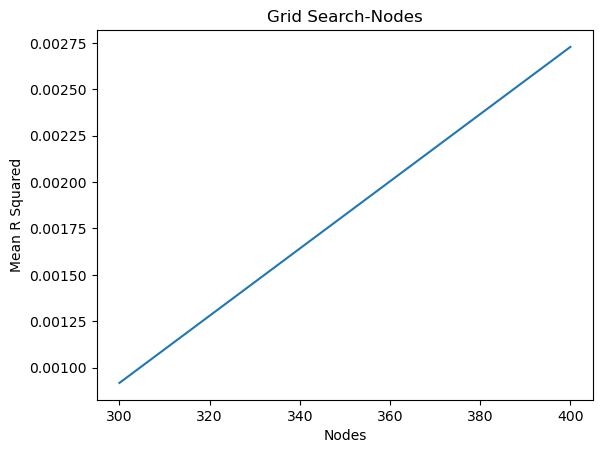

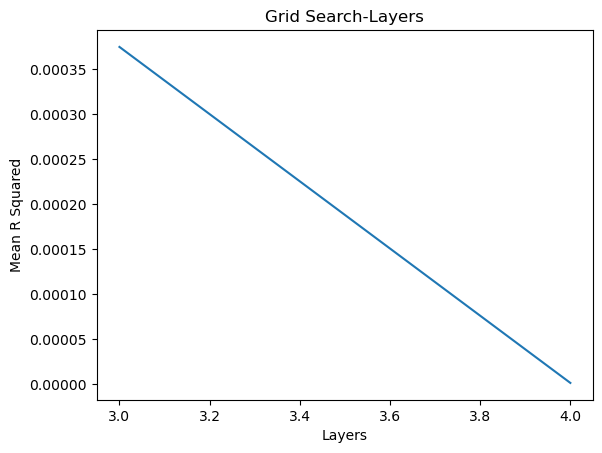

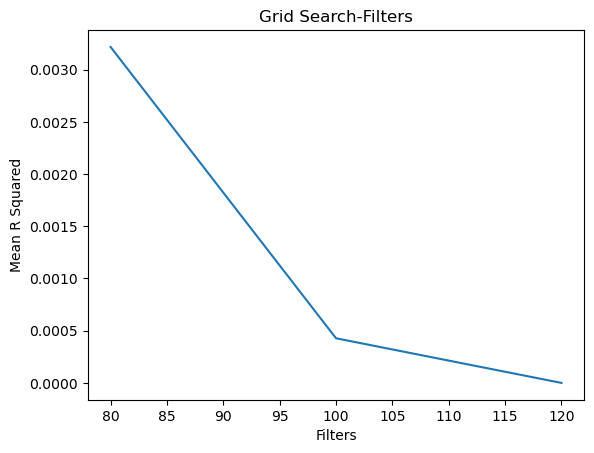

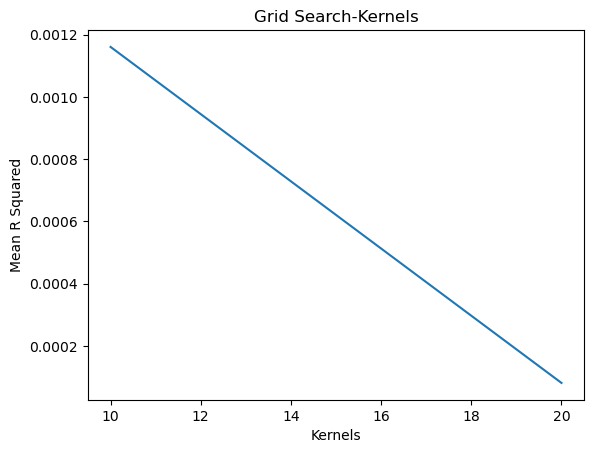

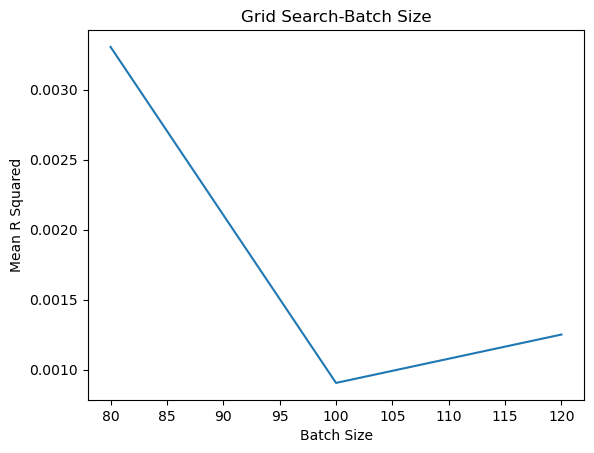

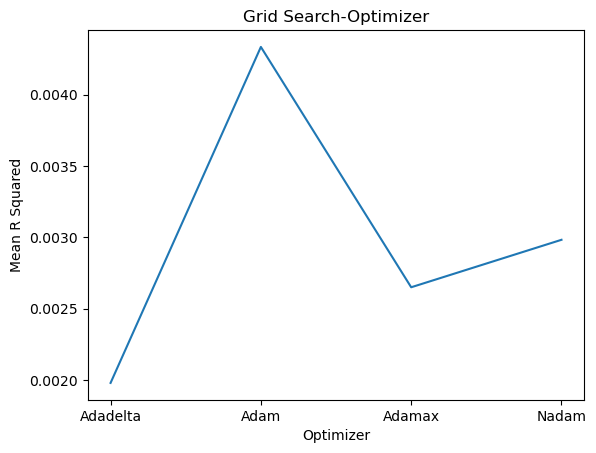

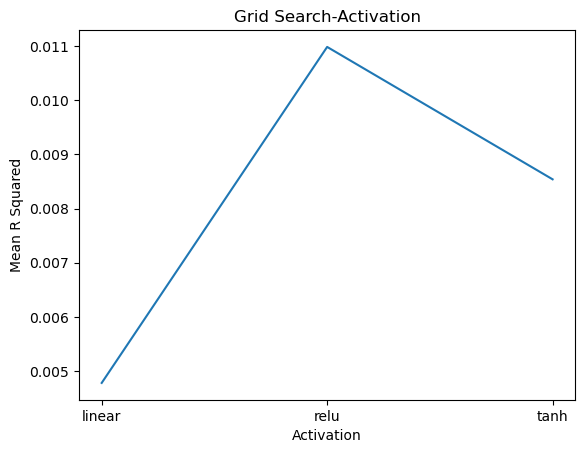

In [7]:
#create new data frame that gives mean r squared and plot
f1= plt.figure()
f2= plt.figure()
f3= plt.figure()
f4= plt.figure() 
f5= plt.figure()
f6= plt.figure()
f7= plt.figure()


print(GS_Nodes)
for i in Nodes_Results:
    print(i)
    
GS_Nodes_Grouped=(GS_Nodes.groupby(['Nodes']).mean())
print(GS_Nodes_Grouped)

# plot results
ax1 = f1.add_subplot(111)
ax1.plot(GS_Nodes_Grouped)
ax1.set_xlabel("Nodes")
ax1.set_ylabel("Mean R Squared")
ax1.set_title ("Grid Search-Nodes")




print(GS_Layers)
for i in Layers_Results:
    print(i)
    
GS_Layers_Grouped=(GS_Layers.groupby(['Layers']).mean())
print(GS_Layers_Grouped)

# plot results
ax2 = f2.add_subplot(111)
ax2.plot(GS_Layers_Grouped)
ax2.set_xlabel("Layers")
ax2.set_ylabel("Mean R Squared")
ax2.set_title ("Grid Search-Layers")

print(GS_Filters)
for i in Filters_Results:
    print(i)
    
GS_Filters_Grouped=(GS_Filters.groupby(['Filters']).mean())
print(GS_Filters_Grouped)

# plot results

ax3 = f3.add_subplot(111)
ax3.plot(GS_Filters_Grouped)
ax3.set_xlabel("Filters")
ax3.set_ylabel("Mean R Squared")
ax3.set_title ("Grid Search-Filters")



print(GS_Kernels)
for i in Kernels_Results:
    print(i)
    
GS_Kernels_Grouped=(GS_Kernels.groupby(['Kernels']).mean())
print(GS_Kernels_Grouped)

# plot results
ax4 = f4.add_subplot(111)
ax4.plot(GS_Kernels_Grouped)
ax4.set_xlabel("Kernels")
ax4.set_ylabel("Mean R Squared")
ax4.set_title ("Grid Search-Kernels")


print(GS_Batch_Sizes)
for i in Batch_Sizes_Results:
    print(i)
    
GS_Batch_Sizes_Grouped=(GS_Batch_Sizes.groupby(['Batch Sizes']).mean())
print(GS_Batch_Sizes_Grouped)

# plot results
ax5 = f5.add_subplot(111)
ax5.plot(GS_Batch_Sizes_Grouped)
ax5.set_xlabel("Batch Size")
ax5.set_ylabel("Mean R Squared")
ax5.set_title ("Grid Search-Batch Size")


print(GS_Optimizer)
for i in Optimizer_Results:
    print(i)
    
GS_Optimizer_Grouped=(GS_Optimizer.groupby(['Optimizer']).mean())
print(GS_Optimizer_Grouped)

# plot results
ax6 = f6.add_subplot(111)
ax6.plot(GS_Optimizer_Grouped)
ax6.set_xlabel("Optimizer")
ax6.set_ylabel("Mean R Squared")
ax6.set_title ("Grid Search-Optimizer")


print(GS_Activation)
for i in Activation_Results:
    print(i)
    
GS_Activation_Grouped=(GS_Activation.groupby(['Activation']).mean())
print(GS_Activation_Grouped)

# plot results
ax7 = f7.add_subplot(111)
ax7.plot(GS_Activation_Grouped)
ax7.set_xlabel("Activation")
ax7.set_ylabel("Mean R Squared")
ax7.set_title ("Grid Search-Activation")



In [23]:
layers=[3, 4] 
nodes=[300, 400]
nbr_filters= [80,120]            #aka filters
filter_len= [10, 20]               #aka kernel_size
batch_size=[80]
optimizer=[ 'Adam', 'Adamax']
activation = ['relu','linear']
R_Squared=[]

#for grid search of multiple parameters
#Make a table of all the variations and output r squared
Grid_Search=pd.DataFrame()
row=0
Grid_Search["Nodes"]=""
Grid_Search["Layers"]=""
Grid_Search["Filters"]=""
Grid_Search["Kernels"]=""
Grid_Search["Batch_Sizes"]=""
Grid_Search["Optimizer"]=""
Grid_Search["Activation"]=""
for z in runs:
    for i in nodes:
        for j in layers:
            for k in nbr_filters:
                for l in filter_len:
                    for m in batch_size:
                        for n in optimizer:
                            for o in activation:
                                Grid_Search.loc[row]=(i,j,k,l,m,n,o)
                                row+=1
print(len(Grid_Search))

for z in runs:
    for i in nodes:
        for j in layers:
                for k in nbr_filters:
                    for l in filter_len:
                        for m in batch_size:
                            for n in optimizer:
                                for o in activation:
                                    model = train_model(seq_e_train, e_train['Count Freq'], nb_epoch=3,border_mode='same',
                                                inp_len=133, nodes=i, layers=j, nbr_filters=k, filter_len=l, dropout1=0,
                                               dropout2=0,dropout3=0.2, batch_size=m, optimizer=n, activation=o)
                                    e_test = test_data(df=e_test, model=model, obs_col='Count Freq',test_seq=seq_e_test)
                                    r = r2(e_test['Count Freq'], e_test['pred'])
                                    e_test['pred']
                                    R_Squared.append(r)
                                    a= "When there are", i,"nodes", j, "layers", k, "filters", l, "kernels", m, "batch size", n, "optimizer, and", o, "activation,  the r squared value is", r
                                    Results.append(a)
                        
Grid_Search["R Squared"]=R_Squared

print(Grid_Search)

192
Epoch 1/3
71/71 [==============================] - 3s 40ms/step - loss: 0.1079
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 2.1603e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 9.3998e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 41ms/step - loss: 0.0352
Epoch 2/3
71/71 [==============================] - 3s 41ms/step - loss: 1.3647e-06
Epoch 3/3
71/71 [==============================] - 3s 41ms/step - loss: 6.6845e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0628
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 3.7738e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 2.6253e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 41ms/step - loss: 0.0964
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 9.8380e-07
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 4.2749e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 67ms/step - loss: 0.1178
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 2.9880e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 2.5298e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0794
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 1.9908e-06
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 1.0887e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0221
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 1.2700e-06
Epoch 3/3
71/71 [==============================] - 5s 67ms/step - loss: 8.6033e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0607
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 3.7451e-06
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 2.7595e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.0847
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 7.2535e-07
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 2.6318e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.0489
Epoch 2/3
71/71 [==============================] - 5s 76ms/step - loss: 1.3126e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 1.0147e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1065
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 6.4854e-07
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 3.9306e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.0776
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 4.5722e-07
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 2.6433e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2736
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 3.5076e-07
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 2.8923e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2994
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 9.3061e-07
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 3.8203e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.0629
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 4.0104e-07
Epoch 3/3
71/71 [==============================] - 9s 128ms/step - loss: 1.8963e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2466
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 6.3710e-07
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 4.1024e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0983
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 3.1333e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.1894e-06


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


Epoch 1/3
71/71 [==============================] - 3s 40ms/step - loss: 0.0877
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.2087e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 5.0779e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.1100
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.7722e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.0826e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0684
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.4282e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 7.9379e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0872
Epoch 2/3
71/71 [==============================] - 5s 67ms/step - loss: 1.8138e-06
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 8.5764e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0649
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 3.2238e-06
Epoch 3/3
71/71 [==============================] - 5s 67ms/step - loss: 2.2895e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 67ms/step - loss: 0.0680
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 1.6820e-06
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 1.0197e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 65ms/step - loss: 0.2284
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 1.1329e-06
Epoch 3/3
71/71 [==============================] - 5s 65ms/step - loss: 6.5500e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 74ms/step - loss: 0.1578
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 3.7402e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 1.5452e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1065
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 2.0133e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 2.0662e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1760
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 2.3009e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 7.6438e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 74ms/step - loss: 0.0863
Epoch 2/3
71/71 [==============================] - 5s 74ms/step - loss: 2.3560e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 2.1888e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.1844
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 1.4348e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 2.9489e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.1761
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 1.8663e-06
Epoch 3/3
71/71 [==============================] - 9s 128ms/step - loss: 3.3288e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.1567
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 1.3802e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 4.9643e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.3342
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 4.8120e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 3.4394e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.2088
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 8.6271e-07
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 4.7609e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 41ms/step - loss: 0.0785
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.2132e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 1.1815e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1014
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 3.4939e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 2.8348e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.0971
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 1.3128e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 5.7664e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.0143
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 9.4658e-07
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 7.2241e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1552
Epoch 2/3
71/71 [==============================] - 5s 69ms/step - loss: 1.7351e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 5.2500e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1731
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.0494e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 4.0722e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.0650
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.9123e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 8.8042e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.2660
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 3.0584e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 1.9057e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.1061
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 2.0212e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 1.1494e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.0872
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 1.9833e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 1.7655e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.1100
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 1.1878e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 4.1334e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.2196
Epoch 2/3
71/71 [==============================] - 9s 131ms/step - loss: 2.9778e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 5.7464e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3539
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 4.8577e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.0337e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.2148
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 2.0275e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.9492e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3996
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.0491e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 2.8192e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1494
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.7727e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 2.3427e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1071
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 3.0429e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 2.3779e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 43ms/step - loss: 0.1138
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 3.5995e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 5.7285e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1305
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.2900e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 2.2911e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1265
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.4893e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 4.3931e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1732
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.1737e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 3.1839e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1354
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.3908e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 2.3860e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1191
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 3.3011e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 2.7641e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.1187
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 2.6529e-06
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 2.5186e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.1234
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 9.3130e-07
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 2.3481e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.1902
Epoch 2/3
71/71 [==============================] - 6s 79ms/step - loss: 1.8777e-06
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 6.8922e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.1878
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 8.4295e-07
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 3.1441e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3343
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 4.4003e-07
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 3.8655e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3013
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.8317e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 5.0039e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.0643
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.5620e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 4.3353e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.1359
Epoch 2/3
71/71 [==============================] - 9s 131ms/step - loss: 1.8458e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.8842e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0579
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.5635e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.4163e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0692
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 7.3490e-07
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 5.3004e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 39ms/step - loss: 0.0679
Epoch 2/3
71/71 [==============================] - 3s 39ms/step - loss: 2.9097e-06
Epoch 3/3
71/71 [==============================] - 3s 39ms/step - loss: 2.3538e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0881
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.8776e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.5782e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 65ms/step - loss: 0.0411
Epoch 2/3
71/71 [==============================] - 5s 65ms/step - loss: 8.3536e-07
Epoch 3/3
71/71 [==============================] - 5s 65ms/step - loss: 4.6379e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0815
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 9.9112e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 4.6344e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1335
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 7.4056e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 4.9673e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1079
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 2.1146e-06
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 1.9232e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 74ms/step - loss: 0.1457
Epoch 2/3
71/71 [==============================] - 5s 76ms/step - loss: 5.1921e-07
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 4.2707e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1232
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 4.6701e-07
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 3.9813e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1263
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 1.7026e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 5.0823e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1224
Epoch 2/3
71/71 [==============================] - 5s 74ms/step - loss: 2.7992e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 2.3290e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 128ms/step - loss: 0.3249
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 4.4768e-07
Epoch 3/3
71/71 [==============================] - 9s 128ms/step - loss: 4.1566e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2084
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 4.0042e-07
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 3.9708e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.3797
Epoch 2/3
71/71 [==============================] - 9s 129ms/step - loss: 7.7556e-07
Epoch 3/3
71/71 [==============================] - 9s 128ms/step - loss: 4.0067e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.3803
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 1.4365e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 7.5982e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0853
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 2.8238e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.6039e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.1075
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 2.5886e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.3791e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.1241
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.7108e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 5.9472e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0552
Epoch 2/3
71/71 [==============================] - 3s 39ms/step - loss: 2.1394e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.9092e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.2112
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 3.8855e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 2.8859e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0707
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 9.8091e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 3.9644e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1168
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 4.4304e-07
Epoch 3/3
71/71 [==============================] - 5s 67ms/step - loss: 3.6042e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1147
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 3.9126e-06
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 4.0015e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1379
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 9.2395e-07
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 4.5343e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.0961
Epoch 2/3
71/71 [==============================] - 5s 74ms/step - loss: 1.5807e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 5.8781e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1646
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 1.6869e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 6.0388e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1404
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 1.5640e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 9.3044e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2497
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 2.9004e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 2.3370e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 129ms/step - loss: 0.1111
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 2.7238e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 2.3937e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2325
Epoch 2/3
71/71 [==============================] - 9s 128ms/step - loss: 7.8955e-07
Epoch 3/3
71/71 [==============================] - 9s 128ms/step - loss: 6.6568e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 128ms/step - loss: 0.1662
Epoch 2/3
71/71 [==============================] - 9s 128ms/step - loss: 6.3528e-07
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 3.0959e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1085
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 7.8155e-07
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 5.4287e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1333
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 1.3966e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 5.1351e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1098
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.5075e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 2.3459e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1042
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 1.7831e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 4.0749e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1739
Epoch 2/3
71/71 [==============================] - 5s 70ms/step - loss: 1.9241e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.4954e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1300
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.5067e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.3308e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1039
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.5520e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.3188e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1228
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.2687e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.9613e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.1624
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 2.1520e-06
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 1.8818e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.1385
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 1.8608e-06
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 1.1341e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.1557
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 2.2251e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 1.9339e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.1547
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 8.0281e-07
Epoch 3/3
71/71 [==============================] - 6s 79ms/step - loss: 2.6732e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.2576
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 5.6937e-07
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.8681e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.0230
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 2.8884e-07
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.3966e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.2987
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.8798e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.2346e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.1367
Epoch 2/3
71/71 [==============================] - 9s 131ms/step - loss: 2.1594e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 3.5270e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.0911
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 1.7264e-06
Epoch 3/3
71/71 [==============================] - 3s 43ms/step - loss: 1.3233e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.0809
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.7972e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 8.5248e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.0894
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 3.2586e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 1.8734e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1304
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.5643e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 4.5866e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1643
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 3.1698e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 2.6173e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1721
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 3.1247e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 3.9789e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1538
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.2865e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 2.9767e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.2667
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.0831e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 4.7874e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.0909
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 2.0982e-06
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 8.5157e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.1286
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 2.5401e-06
Epoch 3/3
71/71 [==============================] - 6s 79ms/step - loss: 2.1790e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.1039
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 1.5627e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 1.2883e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.2234
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 1.5293e-06
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 3.3877e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.0195
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.8518e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.0359e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 10s 130ms/step - loss: 0.7234
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.6528e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.4452e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.2543
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.3705e-06
Epoch 3/3
71/71 [==============================] - 9s 132ms/step - loss: 9.1139e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.5567
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.4903e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 7.6604e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0300
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.1912e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 2.6653e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 39ms/step - loss: 0.1419
Epoch 2/3
71/71 [==============================] - 3s 39ms/step - loss: 9.6814e-07
Epoch 3/3
71/71 [==============================] - 3s 39ms/step - loss: 6.6811e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0681
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 3.4910e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.0327e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.1189
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 2.8758e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 2.3291e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 65ms/step - loss: 0.0717
Epoch 2/3
71/71 [==============================] - 5s 65ms/step - loss: 1.2214e-06
Epoch 3/3
71/71 [==============================] - 5s 65ms/step - loss: 7.6506e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0803
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 7.1471e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 6.8944e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0275
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 8.8298e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 2.5810e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1120
Epoch 2/3
71/71 [==============================] - 5s 65ms/step - loss: 1.6038e-06
Epoch 3/3
71/71 [==============================] - 5s 67ms/step - loss: 4.4510e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 74ms/step - loss: 0.1407
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 1.7072e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 4.9703e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.0737
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 2.8863e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 2.0879e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1069
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 1.2611e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 6.4774e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1393
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 2.2753e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 1.9593e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 128ms/step - loss: 0.2249
Epoch 2/3
71/71 [==============================] - 9s 128ms/step - loss: 3.0468e-06
Epoch 3/3
71/71 [==============================] - 9s 128ms/step - loss: 2.3902e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 128ms/step - loss: 0.3782
Epoch 2/3
71/71 [==============================] - 9s 128ms/step - loss: 6.6672e-07
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 3.8236e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.0188
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 2.0397e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 1.0836e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 10s 128ms/step - loss: 0.1670
Epoch 2/3
71/71 [==============================] - 9s 128ms/step - loss: 7.5355e-07
Epoch 3/3
71/71 [==============================] - 9s 128ms/step - loss: 5.0068e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0505
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.6563e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 1.2104e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0527
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 2.3519e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 2.0523e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.1504
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 1.1760e-06
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 8.3664e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 40ms/step - loss: 0.0342
Epoch 2/3
71/71 [==============================] - 3s 40ms/step - loss: 5.0801e-07
Epoch 3/3
71/71 [==============================] - 3s 40ms/step - loss: 3.7230e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1044
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 4.3587e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 3.3225e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.0457
Epoch 2/3
71/71 [==============================] - 5s 67ms/step - loss: 4.7495e-06
Epoch 3/3
71/71 [==============================] - 5s 67ms/step - loss: 2.8254e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1126
Epoch 2/3
71/71 [==============================] - 5s 67ms/step - loss: 6.8132e-07
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 5.0294e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 66ms/step - loss: 0.1223
Epoch 2/3
71/71 [==============================] - 5s 66ms/step - loss: 1.0218e-06
Epoch 3/3
71/71 [==============================] - 5s 66ms/step - loss: 3.9020e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 74ms/step - loss: 0.2770
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 3.5059e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 2.9103e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 75ms/step - loss: 0.1252
Epoch 2/3
71/71 [==============================] - 5s 75ms/step - loss: 1.4706e-06
Epoch 3/3
71/71 [==============================] - 5s 75ms/step - loss: 2.9470e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 74ms/step - loss: 0.1263
Epoch 2/3
71/71 [==============================] - 5s 74ms/step - loss: 4.0911e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 3.4768e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 74ms/step - loss: 0.1365
Epoch 2/3
71/71 [==============================] - 5s 74ms/step - loss: 1.6364e-06
Epoch 3/3
71/71 [==============================] - 5s 74ms/step - loss: 9.7705e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2026
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 8.3099e-07
Epoch 3/3
71/71 [==============================] - 9s 129ms/step - loss: 5.8711e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2153
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 1.6542e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 9.0161e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.2286
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 7.1713e-07
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 3.1746e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 127ms/step - loss: 0.0679
Epoch 2/3
71/71 [==============================] - 9s 127ms/step - loss: 3.2159e-06
Epoch 3/3
71/71 [==============================] - 9s 127ms/step - loss: 2.2837e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1121
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 3.9670e-06
Epoch 3/3
71/71 [==============================] - 3s 41ms/step - loss: 2.7246e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1202
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.4886e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 1.8429e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 4s 42ms/step - loss: 0.0642
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.3505e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 1.8220e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 44ms/step - loss: 0.1022
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.1985e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 1.8776e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1129
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 6.5599e-07
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 2.1806e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.0151
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.0260e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 6.8850e-08
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1057
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.3838e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 6.6844e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.1536
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.4809e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.9975e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.0951
Epoch 2/3
71/71 [==============================] - 6s 77ms/step - loss: 6.4980e-07
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 3.3747e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.2376
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 1.9818e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 3.1600e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.1345
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 1.8646e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 1.2632e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 80ms/step - loss: 0.1848
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 9.9298e-07
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 2.6437e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.2744
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.3322e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 5.0741e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3313
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 2.5859e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 2.3820e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3991
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 1.9746e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 1.5348e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3127
Epoch 2/3
71/71 [==============================] - 9s 131ms/step - loss: 4.6166e-07
Epoch 3/3
71/71 [==============================] - 9s 133ms/step - loss: 2.4805e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.1149
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.1299e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 1.0133e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.0762
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 2.6061e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 1.9121e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.0655
Epoch 2/3
71/71 [==============================] - 3s 42ms/step - loss: 8.9193e-07
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 4.0317e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 3s 42ms/step - loss: 0.0383
Epoch 2/3
71/71 [==============================] - 3s 43ms/step - loss: 2.6421e-06
Epoch 3/3
71/71 [==============================] - 3s 42ms/step - loss: 1.8911e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 68ms/step - loss: 0.1802
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.7166e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.0405e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.2213
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 1.1878e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 6.7967e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.2787
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.5588e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 1.5811e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 5s 68ms/step - loss: 0.0901
Epoch 2/3
71/71 [==============================] - 5s 68ms/step - loss: 2.1581e-06
Epoch 3/3
71/71 [==============================] - 5s 68ms/step - loss: 4.2351e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.1550
Epoch 2/3
71/71 [==============================] - 6s 78ms/step - loss: 2.0451e-06
Epoch 3/3
71/71 [==============================] - 6s 80ms/step - loss: 1.5536e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.1342
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 2.3349e-06
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 1.9093e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 78ms/step - loss: 0.2701
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 3.9029e-06
Epoch 3/3
71/71 [==============================] - 5s 77ms/step - loss: 2.5168e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 6s 77ms/step - loss: 0.2237
Epoch 2/3
71/71 [==============================] - 5s 77ms/step - loss: 2.6757e-06
Epoch 3/3
71/71 [==============================] - 6s 78ms/step - loss: 1.3232e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.1763
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 3.5837e-07
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 2.9341e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.4883
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 3.1045e-06
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 2.1969e-06
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3065
Epoch 2/3
71/71 [==============================] - 9s 132ms/step - loss: 4.9159e-07
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 4.0935e-07
Epoch 1/3


/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


71/71 [==============================] - 9s 130ms/step - loss: 0.3086
Epoch 2/3
71/71 [==============================] - 9s 130ms/step - loss: 9.0387e-07
Epoch 3/3
71/71 [==============================] - 9s 130ms/step - loss: 2.7202e-07
     Nodes  Layers  Filters  Kernels  Batch_Sizes Optimizer Activation  \
0      300       3       80       10           80      Adam       relu   
1      300       3       80       10           80      Adam     linear   
2      300       3       80       10           80    Adamax       relu   
3      300       3       80       10           80    Adamax     linear   
4      300       3       80       20           80      Adam       relu   
..     ...     ...      ...      ...          ...       ...        ...   
187    400       4      120       10           80    Adamax     linear   
188    400       4      120       20           80      Adam       relu   
189    400       4      120       20           80      Adam     linear   
190    400       4    

/tmp/ipykernel_1952487/2783961118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


In [25]:
print(Grid_Search["R Squared"].max())

Grid_Search.to_csv("Grid Search 02-28-23.csv")

0.025122639871836706
